In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from math import sqrt
import random
import os

<h2>Dataset</h2>

In [2]:
class CustomDataset(Dataset):
    """
    A custom dataset class for loading data from a CSV file.

    Args:
        csv_file (str): Path to the CSV file containing image filenames and scores.
        root_dir (str): Root directory containing the image files.
        transform (callable, optional): Optional transform to be applied to the images.

    Attributes:
        data (pandas.DataFrame): DataFrame containing the data loaded from the CSV file.
        root_dir (str): Root directory containing the image files.
        transform (callable, optional): Optional transform to be applied to the images.
    """
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name)
        scores = np.hstack(self.data.iloc[idx, 1:].values).astype(np.float32)
        scores = torch.from_numpy(scores)
        if self.transform:
            image = self.transform(image)
        return image, scores

In [3]:
test_loader = torch.load('test_loader.pt')
test_dataset = test_loader.dataset

<h2>Models</h2>

In [4]:
class ResnetsRegressionModel(nn.Module):
    """
    A regression model based on ResNets architecture.

    Args:
        backbone (str): The ResNet backbone type, e.g., "resnet18", "resnet34", or "resnet50".
        pretrained (bool): Whether to load pretrained weights. Default is True.
    """
    def __init__(self, backbone, pretrained=True):
        super(ResnetsRegressionModel, self).__init__()
        # Load pre-trained resnets model
        self.backbone = backbone
        if backbone == "resnet18":
            self.model = models.resnet18(pretrained=pretrained)
        elif backbone == "resnet34":
            self.model = models.resnet34(pretrained=pretrained)
        elif backbone == "resnet50":
            self.model = models.resnet50(pretrained=pretrained)

        # Freeze the parameters so they are not updated during training
        for param in self.model.parameters():
            param.requires_grad = False
        # Modify the last fully connected layer for regression
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.model(x)


class EfficientnetsRegressionModel(nn.Module):
    """
    A regression model based on EfficientNets architecture.

    Args:
        backbone (str): The EfficientNet backbone type, e.g., "efficientnet_b0", "efficientnet_b1", "efficientnet_b2", or "efficientnet_b3".
        pretrained (bool): Whether to load pretrained weights. Default is True.
    """
    def __init__(self, backbone, pretrained=True):
        super(EfficientnetsRegressionModel, self).__init__()
        # Load pre-trained model
        self.backbone = backbone
        if backbone == "efficientnet_b0":
            self.model = models.efficientnet_b0(pretrained=pretrained)
        elif backbone == "efficientnet_b1":
            self.model = models.efficientnet_b1(pretrained=pretrained)
        elif backbone == "efficientnet_b2":
            self.model = models.efficientnet_b2(pretrained=pretrained)
        elif backbone == "efficientnet_b3":
            self.model = models.efficientnet_b3(pretrained=pretrained)

        # Freeze the parameters so they are not updated during training
        for param in self.model.parameters():
            param.requires_grad = False

        # Modify the last classifier for regression
        self.model.classifier = nn.Sequential(
            nn.Linear(self.model.classifier[1].in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.model(x)


class InceptionRegressionModel(nn.Module):
    """
    A regression model based on InceptionV3 architecture.

    Args:
        pretrained (bool): Whether to load pretrained weights. Default is True.
    """
    def __init__(self, pretrained=True):
        super(InceptionRegressionModel, self).__init__()
        # Load pre-trained model
        self.backbone = "inception_v3"
        self.model = models.googlenet(pretrained=pretrained)
        # Freeze the parameters so they are not updated during training
        for param in self.model.parameters():
            param.requires_grad = False
        # Modify the last fully connected layer for regression
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.model(x)


class VisionTransformersRegressionModel(nn.Module):
    """
    A regression model based on Vision Transformers architecture.

    Args:
        backbone (str): The Vision Transformer backbone type, e.g., "vit_b_16" or "vit_h_14".
        pretrained (bool): Whether to load pretrained weights. Default is True.
    """
    def __init__(self, backbone, pretrained=True):
        super(VisionTransformersRegressionModel, self).__init__()
        # Load pre-trained model
        self.backbone = backbone
        if backbone == "vit_b_16":
            self.model = models.vit_b_16(pretrained=pretrained)

        elif backbone == "vit_h_14":
            self.model = models.vit_h_14(pretrained=pretrained)

        # Freeze the parameters so they are not updated during training
        for param in self.model.parameters():
            param.requires_grad = False
        # Modify the last fully connected layer for regression
        self.model.heads = nn.Sequential(
            nn.Linear(self.model.heads.head.in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2),  # Output 2 values for regression
            nn.Sigmoid()  # Sigmoid activation to ensure values between 0 and 1
        )

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.model(x)


def get_model(backbone):
    """
    Get the regression model based on the specified backbone.

    Args:
        backbone (str): The backbone type of the model.

    Returns:
        nn.Module: The regression model.
    """
    if backbone in ["resnet18", "resnet34", "resnet50"]:
        return ResnetsRegressionModel(backbone)

    elif backbone in ["efficientnet_b0", "efficientnet_b1", "efficientnet_b2", "efficientnet_b3"]:
        return EfficientnetsRegressionModel(backbone)

    elif backbone == "inception_v3":
        return InceptionRegressionModel()

    elif backbone in ["vit_b_16", "vit_h_14"]:
        return VisionTransformersRegressionModel(backbone)

    else:
        return
    
def load_model(checkpoint, backbone):
    """
    Load a pre-trained model from a checkpoint file.

    Args:
        checkpoint (str): Path to the checkpoint file containing model parameters.
        backbone (str): The backbone architecture of the model.

    Returns:
        torch.nn.Module: The loaded model.
    """
    model = get_model(backbone)
    model.load_state_dict(torch.load(checkpoint))
    return model

<h2>Predict</h2>

In [5]:
def predict(model, criterion, dataloader):
    """
    Predict outputs using a trained model and calculate test metrics.

    Args:
        model (torch.nn.Module): The trained model for prediction.
        criterion: The loss function (e.g., torch.nn.MSELoss).
        dataloader (torch.utils.data.DataLoader): DataLoader for the test dataset.

    Returns:
        tuple: A tuple containing test losses, test labels, and test predictions.
    """
    test_losses = []
    test_predictions_all = []
    test_labels_all = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = model(inputs)
            test_loss = criterion(outputs, labels).item()
            test_losses.append(test_loss)
            test_predictions_all.extend(outputs.numpy())
            test_labels_all.extend(labels.numpy())
    
    # Calculate test metrics
    test_losses = np.array(test_losses)
    test_predictions_all = np.array(test_predictions_all)
    test_labels_all = np.array(test_labels_all)
    test_mse = mean_squared_error(test_labels_all, test_predictions_all)
    test_mae = mean_absolute_error(test_labels_all, test_predictions_all)
    test_rmse = sqrt(test_mse)
    test_r2 = r2_score(test_labels_all, test_predictions_all)
    print('Test Loss: %.3f, MSE: %.3f, MAE: %.3f, RMSE: %.3f, R-squared: %.3f' %
          (np.mean(test_losses), test_mse, test_mae, test_rmse, test_r2))
    
    return test_losses, test_labels_all, test_predictions_all

<h2>Evaluation</h2>
<h3>Quantitative evaluation</h3>

In [6]:
# Randomly select 10 images from the test set
random_indices = random.sample(range(len(test_loader.dataset)), 10)

In [7]:
criterion = nn.MSELoss()
resnet18_best_model = load_model("../training/vit_b_16/models/vit_b_16_best_model.pth", "vit_b_16",)

/Users/nsbaa/Desktop/long-covid-venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nsbaa/Desktop/long-covid-venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
test_losses, test_labels_all, test_predictions_all = predict(resnet18_best_model, criterion, test_loader)

Test Loss: 0.042, MSE: 0.042, MAE: 0.121, RMSE: 0.205, R-squared: 0.702


<h3>Qualitative evaluation</h3>
<h4>Visualization:</h4>

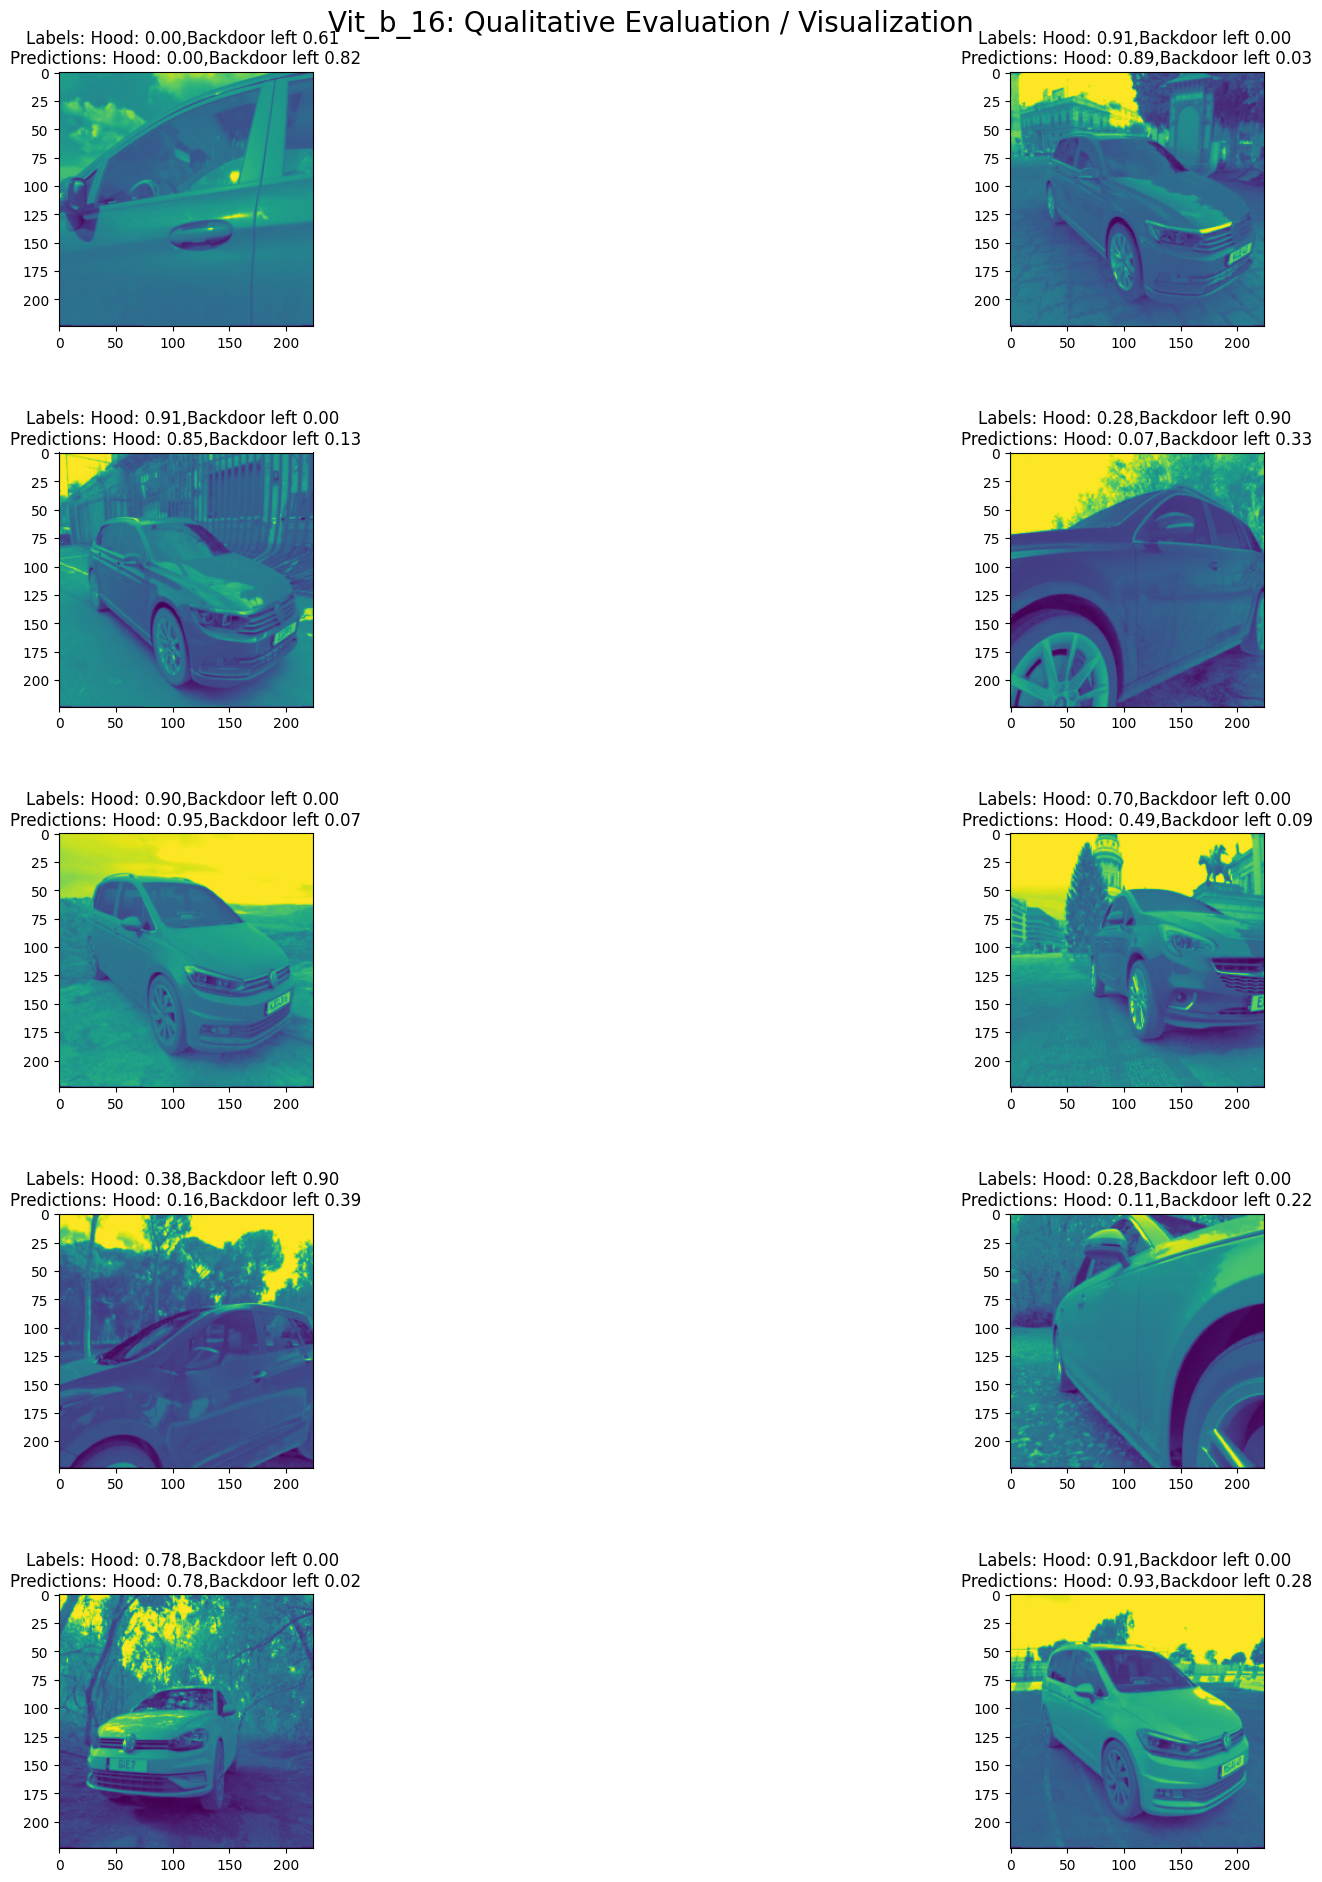

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
fig.tight_layout(pad=7.0) # Or equivalently,  "plt.tight_layout()"
fig.suptitle('Vit_b_16: Qualitative Evaluation / Visualization', fontsize=20)

i = 0
for oo in range(0,5):
    for ii in range(0, 2):
        index = random_indices[i]
        labels = test_labels_all[index]
        preds = test_predictions_all[index]
        title = 'Labels: Hood: %.2f,Backdoor left %.2f \nPredictions: Hood: %.2f,Backdoor left %.2f' % (labels[0], labels[1], preds[0], preds[1])
        image, label = test_dataset[index]
        axes[oo, ii].imshow(image[0])
        axes[oo, ii].set_title(title)
        i += 1
        
plt.show()